In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
MONITORING_DATA_DIR = "../monitoring_data_20220310_112950"

In [23]:
def load_file_to_df(input_filename: str, sep:str =',') -> pd.DataFrame:
    return pd.read_csv(input_filename, sep=sep)

In [24]:
def update_timestamp_colum(df: pd.DataFrame, timestamp_columnname: str) -> pd.DataFrame:
    df[timestamp_columnname] = pd.to_datetime(df[timestamp_columnname])
    df.set_index(timestamp_columnname)

    # Set the timestamp column as the first column
    cols = list(df)
    cols.insert(0, cols.pop(cols.index(timestamp_columnname)))
    df = df.loc[:, cols]
    return df

In [25]:
def draw_line_graph(df: pd.DataFrame, timestamp_columnname: str,
                    graph_value_columnname: str, title: str) -> None:

    df[timestamp_columnname] = pd.to_datetime(df[timestamp_columnname])
    df.set_index(timestamp_columnname)

    plt.style.use("fast")
    plt.figure(figsize=(12, 10))
    plt.xlabel("Time")
    plt.ylabel("Response Time (seconds)")
    plt.title(title)
    plt.plot(df[graph_value_columnname])

In [31]:
def display_statistics(df: pd.DataFrame, value_columnname) -> None:
    print(f"Maximum value:\t{round(df[value_columnname].max(), 1)}")
    print(f"Mean value:\t\t{round(df[value_columnname].mean(), 1)}")
    print(f"95th quantile:\t{round(df[value_columnname].quantile(0.95), 1)}")

In [34]:
def display_martha_response_times(input_filename: str) -> None:
    timestamp_columnname = "martha.start_time"
    graph_value_columnname = "martha.response_duration"
    df = load_file_to_df(input_filename)
    df = update_timestamp_colum(df, timestamp_columnname)
    draw_line_graph(df, timestamp_columnname, graph_value_columnname, "Martha Response Time")

    display_statistics(df, graph_value_columnname)

Maximum value:	58.2
Mean value:		30.0
95th quantile:	58.1


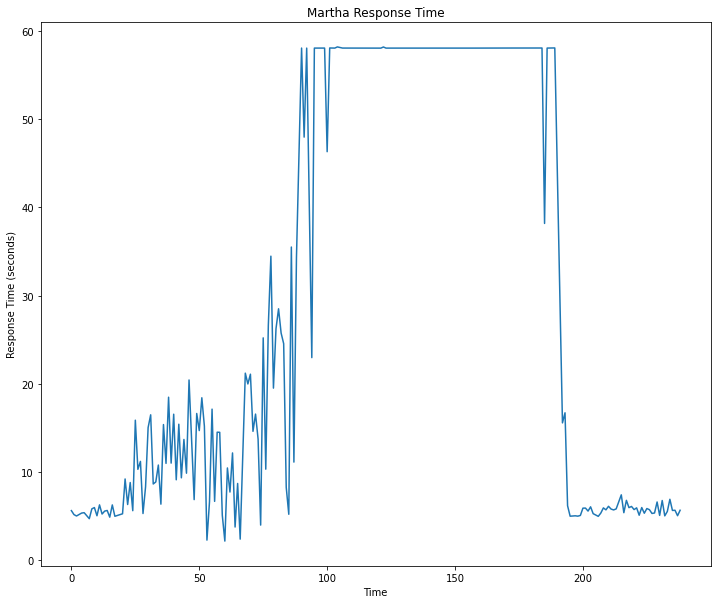

In [35]:
display_martha_response_times(f"{MONITORING_DATA_DIR}/martha_response_time_20220310_112950.csv")